# Ludicrous-Speed GWAS:
# FaST-LMM applied to One Million Individuals


##### Version 0.0.1
Microsoft Research, September 2, 2016

This notebook shows how to run a 'Ludicrous-Speed FaST-LMM' on Azure. It goes step-by-step through the process, both to help explain the process and to help check that everything is set up correctly.

> Question: Should the name be 'Ludicrous-Speed FaST-LMM'? 'Low-Rank Optimized FaST-LMM'? ??? FaST-LMM-Scale

### Notebook preparation and general use #!!!explain the tree thing

Run this cell only if these packages need to be install or updated.

In [ ]:
!pip install fastlmm
!pip install azure
!pip install azure-batch
!pip install azure-storage">="0.33.0

To prepare this notebook to run analyses, please run the following script.

In [2]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output)
import logging
logging.basicConfig(level=logging.WARNING)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

import time
import datetime

### Regular FaST-LMM

First, let's start by confirming that we can run regular FaST-LMM. This will confirm that we have Python set up correctly and have install the necessary packages. For details, see the README.md at https://github.com/MicrosoftGenomics/FaST-LMM and the https://github.com/MicrosoftGenomics/FaST-LMM/blob/master/doc/ipynb/FaST-LMM.ipynb notebook. On my 2-processor laptop machine, this takes 7 seconds.

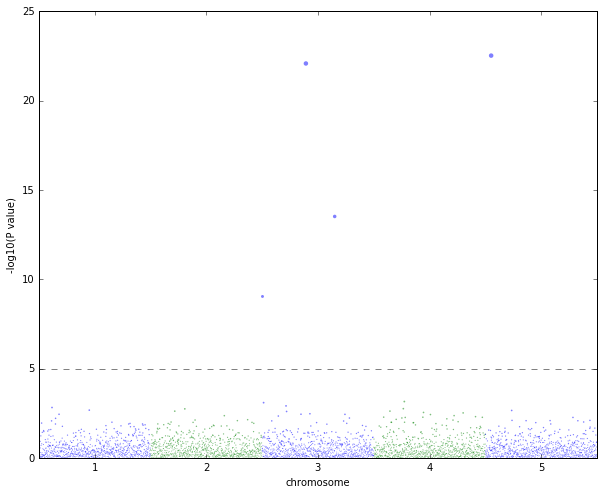

lambda=1.0078
time=0:00:02.267000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,2.990685e-23,-0.418653,0.040052,0.424521,0.0,0.451117
1,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251922e-23,0.416495,0.040300,0.420587,0.0,0.279710
2,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279710
3,3,snp433_m0_.14m1_.11,3,2003,2003,9.202499e-10,0.268289,0.042973,0.269670,0.0,0.279710
4,274,snp2832_m0_.46m1_.1,4,3274,3274,7.069762e-04,-0.170421,0.050003,0.151124,0.0,0.542046
5,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279710
6,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239806e-03,-0.150705,0.046396,0.144180,0.0,0.279710
7,117,snp751_m0_.04m1_.25,1,117,117,1.527432e-03,0.152430,0.047827,0.141523,0.0,0.614963
8,265,snp1440_m0_.35m1_.32,4,3265,3265,1.771049e-03,-0.136281,0.043358,0.139610,0.0,0.542046
9,307,snp2162_m0_.61m1_.42,2,1307,1307,1.816576e-03,0.143296,0.045700,0.139280,0.0,0.534262


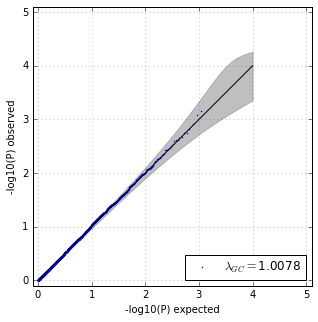

In [2]:
# import the algorithm
from fastlmm.association import single_snp
t2 = time.time()

# set up data
##############################
bed_fn = "../../tests/datasets/synth/all"
pheno_fn = "../../tests/datasets/synth/pheno_10_causals.txt"
cov_fn = "../../tests/datasets/synth/cov.txt"

# run gwas
###################################################################
results_df = single_snp(bed_fn,  pheno_fn, covar=cov_fn, count_A1=True)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
print "time={0}".format(datetime.timedelta(seconds=time.time()-t2))
results_df.head(n=10)

### Ludicrous-Speed GWAS

Now let's move to the ludirous-speed version of FaST-LMM.

#### Installing

> * Future: Installable from PyPi

> * Future: Runnable on Linux

For now, this version of FaST-LMM runs on Windows. To get the new code, copy it from my machine, creating four new folders on a machine. For example, we copy

*    \\\\carlk4\c\$\source\carlk\fastlmm to c:\source\fastlmm
*    \\\\carlk4\c\$\source\carlk\pysnptools to c:\source\pysnptools
*    \\\\carlk4\c\$\source\carlk\onemil to c:\source\onemile
*    \\\\carlk4\c\$\source\carlk\azuresnps to c:\source\azuresnps

and then we set the pythonpath to match these local locations.

    set pythonpath=c:\source\fastlmm;c:\source\pysnptools;c:\source\onemil;c:\source\azuresnps




### Testing

We'll run exactly the same example as above.

> Question: Should the function name be 'single_snp2' or something else?

> Question: Should it be part of the standard fastlmm package?

We note the following differences from the old way of running:

* G0 (the SNPs on which to train) and test_snps must both be specified.
* A file_cache must be specified. It tells how to manage intermedate working files. In this case, we'll use a 'LocalCache' which just keeps the file in a local folder. We'll see later options for sharing the files across multiple machine via Azure Storage.
* It runs slower. On my 2-processor laptop machine, the run takes 3 minutes. On this example, the old method is actually better. We're running the new method just purposes of illustation.

> Aside: The new method is slower because has 500 individuals and 5000 training SNPs.
> The old method requires ~500x500x500
> operations (125 Million). The new method requires ~5000x5000x5000 operations (125 Billion),
> so about 1000 times slower. The new method 
> pays off when the number of individuals
> grows to, for example, 1 million and we can keep the number of training SNPs to less around 50,000.

We note an important similarity:

* It returns the same answer.

Loading fam file ../../tests/datasets/synth/all.fam
Loading bim file ../../tests/datasets/synth/all.bim
bed file is open ../../tests/datasets/synth/all.bed
Loading fam file ../../tests/datasets/synth/all.fam
Loading bim file ../../tests/datasets/synth/all.bim
bed file is open ../../tests/datasets/synth/all.bed
About to allocate memmap of G0_data
About to start allocating memmap 'local_cache\G0_data.dat'
Finished allocating memmap 'local_cache\G0_data.dat'. Size is 20000000
Finished with allocation of memmap of G0_data
get_G0_data: Working on part 0 of 2
get_G0_data: Working on part 1 of 2
About to get name of file to np.savez ss_per_snp
About to np.savez ss_per_snp in 'local_cache\ss_per_snp.npz'
About to close_write ss_per_snp
done with ss_per_snp
About to SnpMemMap.write G0_data in 'local_cache\G0_data.dat'
Done with g0.npz and g0.dat
Computing G0.T x G0
starting ata reducer
ata_piece: Working on piece 0 of 2.
0/2
1/2


Traceback (most recent call last):
  File "C:\Anaconda2\lib\logging\__init__.py", line 882, in emit
    stream.write(fs % msg)
  File "C:\Anaconda2\lib\site-packages\ipykernel\iostream.py", line 317, in write
    self._buffer.write(string)
ValueError: I/O operation on closed file
Logged from file single_snp_low.py, line 393


ata_piece 0 of 2: clocktime 01/01/70 00:00:00
ata_piece: Working on piece 1 of 2.
1/2
ata_piece 1 of 2: clocktime 01/01/70 00:00:00
combining ata reducer 0
combining ata reducer 1
gtg: clocktime 01/01/70 00:00:02
Caching chrom 1
About to svd on square 4000. Expected time (4 procs)=01/01/70 00:01:02
Actual time for svd on square=01/01/70 00:00:21
Caching chrom 2
About to svd on square 4000. Expected time (4 procs)=01/01/70 00:01:02
Actual time for svd on square=01/01/70 00:00:21
Caching chrom 3
About to svd on square 4000. Expected time (4 procs)=01/01/70 00:01:02
Actual time for svd on square=01/01/70 00:00:22
Caching chrom 4
About to svd on square 4000. Expected time (4 procs)=01/01/70 00:01:02
Actual time for svd on square=01/01/70 00:00:21
Caching chrom 5
About to svd on square 4000. Expected time (4 procs)=01/01/70 00:01:02
Actual time for svd on square=01/01/70 00:00:24
Starting postsvd reduce for chrom '1' with file downloads
About to read
About to mult
About to save
post svd pie

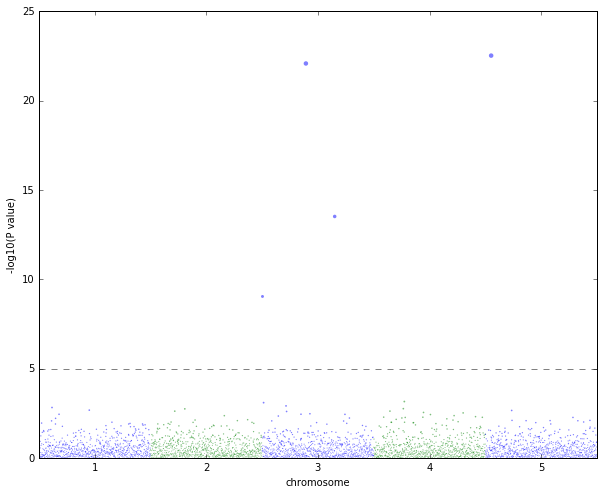

lambda=1.0078
time=0:02:55.827000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,2.990684e-23,-0.418653,0.040052,0.424521,0.0,0.451117
1,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251916e-23,0.416495,0.040300,0.420587,0.0,0.279711
2,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279711
3,3,snp433_m0_.14m1_.11,3,2003,2003,9.202498e-10,0.268289,0.042973,0.269670,0.0,0.279711
4,274,snp2832_m0_.46m1_.1,4,3274,3274,7.069762e-04,-0.170421,0.050003,0.151124,0.0,0.542046
5,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279711
6,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239807e-03,-0.150705,0.046396,0.144180,0.0,0.279711
7,117,snp751_m0_.04m1_.25,1,117,117,1.527432e-03,0.152430,0.047827,0.141523,0.0,0.614963
8,265,snp1440_m0_.35m1_.32,4,3265,3265,1.771049e-03,-0.136281,0.043358,0.139610,0.0,0.542046
9,307,snp2162_m0_.61m1_.42,2,1307,1307,1.816577e-03,0.143296,0.045700,0.139280,0.0,0.534263


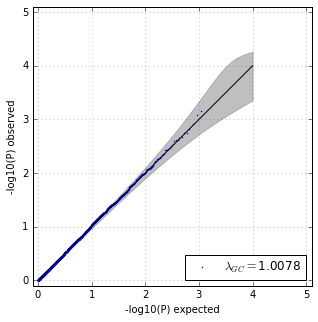

In [3]:
# import the algorithm
from onemil.single_snp_low import single_snp2
from onemil.file_cache import LocalCache

logging.getLogger().setLevel(logging.INFO) #Set logging level to INFO to see more. Set to WARN to see less.
t3 = time.time()

# set up data
##############################
snps = "../../tests/datasets/synth/all"
pheno = "../../tests/datasets/synth/pheno_10_causals.txt"
covar = "../../tests/datasets/synth/cov.txt"

# run gwas
###################################################################
local_cache = LocalCache()
local_cache.rmtree()
results_df = single_snp2(file_cache=local_cache,test_snps=snps, pheno=pheno, covar=covar, G0=snps)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
flutil.manhattan_plot(results_df.as_matrix(["Chr", "ChrPos", "PValue"]),pvalue_line=1e-5,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
print "time={0}".format(datetime.timedelta(seconds=time.time()-t3))
results_df.head(n=10)

## Reusing previous intermediate work

We can re-run without clearing the file_cache. We'll get the answers faster (for be in about 30 seconds) because it reuses some intermediate results. (We'll detail these presently.)

In [4]:
logging.getLogger().setLevel(logging.WARN) #Set logging level to INFO to see more. Set to WARN to see less.
t4=time.time()
results_df = single_snp2(file_cache=local_cache,test_snps=snps, pheno=pheno, covar=covar, G0=snps)
print "time={0}".format(datetime.timedelta(seconds=time.time()-t4))
results_df.head(n=5) #Top five results

time=0:00:23.011000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,52,snp495_m0_.01m1_.04,5,4052,4052,2.990684e-23,-0.418653,0.040052,0.424521,0.0,0.451117
1,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251916e-23,0.416495,0.040300,0.420587,0.0,0.279711
2,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279711
3,3,snp433_m0_.14m1_.11,3,2003,2003,9.202498e-10,0.268289,0.042973,0.269670,0.0,0.279711
4,274,snp2832_m0_.46m1_.1,4,3274,3274,7.069762e-04,-0.170421,0.050003,0.151124,0.0,0.542046


## The program's steps and intermediate files

Let's look at the tree_cache to see what files are there. (With the default set up, look at C:\Source\fastlmm\doc\ipynb\fileshare\local_cache). The four steps to the program and the files each step creates are:

### gtg

* G0_data.dat, G0_data.npz -- This is a form of the training SNPs such it is standardized and such that covariates are regressed out.
* gtg.npz -- This is the SNP x SNP matrix created by multiplying G0_data with itself.
* ss_per_snp.npz -- The sufficient statistics needed to standardize the preceeding files, on the fly, for any any test chromosome.

### svd

* SVinv_etc1.npz, ... SVinv_etc5.npz -- The SVD of gtg for each chromosome.

### post_svd

* U1.dat, U1.npz, ... U5.dat, U5.npz -- The SVD of G0_data for each chromsome.
* U1_pieces ... U5_pieces -- working files for create U1.dat, etc.
* h2_1.npz .. h2_5.npz -- The LMM weight to give the SNPs vs. pure noise.
* UUYetc1.npz ... UUYetc5.npz -- related files

### test_snps

> * Future: Optional output file of results


## Testing only one chromosome

The program always does "leave one out chrom", so for now let's focus on the smaller tasks of testing only on SNPs in chromosome 3. Because we are testing only one chromsome instead of five and because we've used intermete files, the run takes only 5 seconds on my machine.

In [5]:
from pysnptools.snpreader import Bed

logging.getLogger().setLevel(logging.WARN) #Set logging level to INFO to see more. Set to WARN to see less.tree_cache.rmtree() # remove all intermediate files
t5=time.time()
snpreader = Bed(snps,count_A1=True) #Create a reader for the SNPs. It can efficently retreive metadata such as chromosome number.
test_snps3 = snpreader[:,snpreader.pos[:,0]==3] # Test only on chromosome 3
results_df = single_snp2(file_cache=local_cache,test_snps=test_snps3, pheno=pheno, covar=covar, G0=snps)
print "time={0}".format(datetime.timedelta(seconds=time.time()-t5))
results_df.head(n=5) # Top 5 results from chromsome 3

time=0:00:04.707000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251916e-23,0.416495,0.040300,0.420587,0.0,0.279711
1,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279711
2,3,snp433_m0_.14m1_.11,3,2003,2003,9.202498e-10,0.268289,0.042973,0.269670,0.0,0.279711
3,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279711
4,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239807e-03,-0.150705,0.046396,0.144180,0.0,0.279711


## Running as Multiple Processes

The program can run on clusters. Let's see the simpliest example of this by having it run on (up to) four processes on our local machine. For this run, we clear on the intermediate results and re-create them. On my 2-processor laptop the run takes about one minute.

> Tip: If you need to debug more complicated cluster runs, it sometimes helps to re-do the run with LocalMultiProc, the simpliest cluster runner. (You may need to run on a smaller version of your problem.)

> Tip: If you need to debug LocalMultiProc, it sometimes helps to run with LocalMultiPro(...,just_one_process=True), which follows the same code path as normal LocalMultiProc runs, but keeps everything in the same process.

In [6]:
from fastlmm.util.runner import LocalMultiProc
logging.getLogger().setLevel(logging.WARN) #Set logging level to INFO to see more. Set to WARN to see less.tree_cache.rmtree() # remove all intermediate files
t6=time.time()
runner = LocalMultiProc(taskcount=4,just_one_process=False)

local_cache.rmtree() #Clear previous intermediate results
results_df = single_snp2(file_cache=local_cache,test_snps=test_snps3, pheno=pheno, covar=covar, G0=snps, runner=runner)

print "time={0}".format(datetime.timedelta(seconds=time.time()-t6))
results_df.head(n=5)

time=0:00:47.024000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251916e-23,0.416495,0.040300,0.420587,0.0,0.279711
1,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279711
2,3,snp433_m0_.14m1_.11,3,2003,2003,9.202498e-10,0.268289,0.042973,0.269670,0.0,0.279711
3,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279711
4,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239807e-03,-0.150705,0.046396,0.144180,0.0,0.279711


## Clusterizing to Azure: Setup

As a next step, let's see how to run this example on a two-machine Azure cluster. Here are the steps:

> Future: Tell about how much accounts cost and what times to get)

#### Azure Account
* On https://azure.microsoft.com/ create an Azure account. (!!!!check non us)

#### Storage Account
* On https://portal.azure.com create a new storage account named, for example, "flstor" (for "FaST-LMMM storage"), with settings "Resource Manager", "General purpose", "Standard", "Locally-redudant storage", Resource group: "Create New" "flrg" (for FaST-LMM Resource Group), "West US", "Pin to dashboard" !!!pick your name?

#### Create a container in the Storage Account !!!what is a container?
* From the Azure portal, select the storage account, select "Blobs", "+Container", "mapreduce3","Private", "Create". 

> Future: Fix so name of container doesn't need to be "mapreduce3"

#### Batch Account !!!what does batch accoutn mean. Also, what if West US isn't good for them
* On portal page also, create a "Batch Account" (may be under "More services"). I called mine "flbatch" (for "FaST-LMM Batch"), Resource group: "Use existing" "flrg", "West US", "flstor", "Pin to dashboard"

####  Create Python Application Package
* Create a zip file from your Python distribution. I use Anaconda and it is installed at "c:\Anaconda2". Using the Windows file explorer in c:\, I can select "Anaconda2" and then right click and select "Send to". In about three minutes creates a "Anaconda2.zip" on my desktop.

* My dashboard now includes batch account, "flbatch". Going to that batch account, "Applications", "add", "Anaconda2", "1", select Anaconda2.zip, "OK". It uploads the zip file to the storage account. Wait for it to finish sucessfully.

#### Create Pool !!!what is a pool, etc
* My dashboard now includes batch account, "flbatch". Going to that batch account, create a new pool called "pool1", (no display name), "Cloud Services (Windows only)", "Windows Server 2012 R2", "Lastest", "Standard_A4", "Auto scale", "\$TargetDedicated =2;\$NodeDeallocationOption = taskcompletion;", "5", "Disabled", "1", "Pack", "No", "Anaconda2" (verson 1), "0", "Pin to dashboard".

> ### **IMPORTANT** : Set your \$TargetDedicated=0 when your are not using your cluster. At the time of this writing, leaving two A4 machines on for a month costs about \$1100. !!!to run off your machines.

#### Create a local credentials file

In your home directory (for me, it is "c:\Users\carlk", create a subdirectory called "azurebatch". In that directory, created a text file called "cred.txt". It should have five lines and look something like:

    https://flbatch.westus.batch.azure.com
    flbatch
    [BATCH KEY]
    flstor
    [STORAGE KEY]

where the five lines are:

* the URL of your batch account. Found in the Azure Portal by clicking on the batch service.
* the short name of the batch account
* the batch account's primary access key. Found in the Azure Portal by again clicking on the batch service and then clicking on "Keys".
* the short name of the storage account
* the storage account's "key1". Found in the Azure Portal by clicking on the storage account and then clicking on "Access keys".


### Running locally with files in Azure storage !!!still "local" CPU

!!!better if running from VM

As a test, we can run locally using Azure storage.

The results will be the same. You can use the Azure Portal to see the files. Navigate to the storage account then "Blobs", "mapreduce3", "notebook". You'll see folders with names like "G0_data.dat" and "h2_3.npz". On my laptop the run takes just over 90 seconds.

> Tip: Although the Azure Portal gives you full access to Azure Storage, you may prefer third-party tools. I use "CloudBerry Explorer to inspect and manage Azure Storage.


In [9]:
from onemil.tree_cache import AzureStorage

logging.getLogger().setLevel(logging.WARN) #Set logging level to INFO to see more. Set to WARN to see less.tree_cache.rmtree() # remove all intermediate files
t7 = time.time()

azure_storage = AzureStorage("notebook") 
azure_storage.rmtree() #Clear previous intermediate results

results_df = single_snp2(file_cache=azure_storage,test_snps=test_snps3, pheno=pheno, covar=covar, G0=snps)

print "time={0}".format(datetime.timedelta(seconds=time.time()-t7))
results_df.head(n=5)

time=0:01:31.855000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251916e-23,0.416495,0.040300,0.420587,0.0,0.279711
1,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.279711
2,3,snp433_m0_.14m1_.11,3,2003,2003,9.202498e-10,0.268289,0.042973,0.269670,0.0,0.279711
3,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.279711
4,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239807e-03,-0.150705,0.046396,0.144180,0.0,0.279711


### Running Azure Batch

To run this job on Azure Batch, we use the "AzureBatch" runner for all four steps. AzureBatch's input is:

* task_count -- which tells how many pieces to divide the work into. In this case, 4

The AzureBatch runner also requires that input files be under the current working directory, so we move the working directory up to levels and then restore it at the end.

On my computer, this run takes 17 minutes the first time, as it uploads the python code on the Python path. Subsequent runs that check the python path take 10 1/2 minutes. If we skip the check, the run takes 9 1/2 minutes. Compared to running locally, running on a cluster adds overhead. This run sequentally submits four jobs to the cluster, so the overhead for each cluster submission is about two minutes.


> Future: Tell about unsupported Azure batch tool

> Future: Tell about loading python path files (but only once or when changed)

> Future: Fix so doesn't upload working file from fastlmm notebook

> Future: When a task fails should report back the fact and give the stderr. (Now, the first sign is that it fails 50 time to download the value pickle from the reduce step.)

> Future: Explain why so many upload messages and also why the files are split apart in Azure storage

> Future: Explain stdout/stderr. Explain the file structure on the azure nodes and how you can remote to them.

> Future: There should be a command way to clear old dibs files. Perhaps rmtree should do it.

> Future: If there is only one pool in a Azure batch account that shouldn't need to mention it.

> Future: At the start of a run, warn if .traffic already has orphen dibs

> Future: Tell about finding stderr files

> Future: Tell how to do everything from a Windows VM


In [5]:
from onemil.single_snp_low import single_snp2
from pysnptools.snpreader import Bed, Pheno
from onemil.tree_cache import AzureStorage
from fastlmm.util.runner import AzureBatch
import os

logging.getLogger().setLevel(logging.WARN) #Set logging level to INFO to see more. Set to WARN to see less.tree_cache.rmtree() # remove all intermediate files
t8 = time.time()

original_wd = os.getcwd()
try:
    os.chdir("../..")
    snps = "tests/datasets/synth/all"
    pheno = "tests/datasets/synth/pheno_10_causals.txt"
    covar = "tests/datasets/synth/cov.txt"
    snpreader = Bed(snps,count_A1=True) #Create a reader for the SNPs. It can efficently retreive metadata such as chromosome number.
    test_snps3 = snpreader[:,snpreader.pos[:,0]==3] # Test only on chromosome 3

    azure_storage = AzureStorage("notebook")
    runner = AzureBatch(task_count=4,update_python_path=False)

    azure_storage.rmtree() #Clear previous intermediate results
    results_df = single_snp2(file_cache=azure_storage,test_snps=test_snps3, pheno=pheno, covar=covar, G0=snps, runner=runner)
finally:
    os.chdir(original_wd)

print ""
print "time={0}".format(datetime.timedelta(seconds=time.time()-t8))
results_df.head(n=5)


performing 1 range-gets
xfer progress: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00%    1578.94 range-gets/min    performing 1 range-gets
xfer progress: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00%     821.92 range-gets/min    performing 1 range-gets
xfer progress: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00%     705.88 range-gets/min    performing 1 range-gets
xfer progress: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00%     487.80 range-gets/min    
time=0:09:36.846000


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,392,snp1422_m0_.49m1_.5,3,2392,2392,8.251922e-23,0.416495,0.040300,0.420587,0.0,0.27971
1,650,snp1200_m0_.37m1_.36,3,2650,2650,3.048007e-14,-0.328870,0.042021,0.331240,0.0,0.27971
2,3,snp433_m0_.14m1_.11,3,2003,2003,9.202499e-10,0.268289,0.042973,0.269670,0.0,0.27971
3,13,snp1413_m0_.04m1_.03,3,2013,2013,8.161238e-04,0.148719,0.044157,0.149377,0.0,0.27971
4,214,snp2804_m0_.16m1_.3,3,2214,2214,1.239806e-03,-0.150705,0.046396,0.144180,0.0,0.27971


### A Larger Azure Batch run on synthetic data



In [4]:
from onemil.single_snp_low import single_snp2
from onemil.tree_cache import AzureStorage
from fastlmm.util.runner import AzureBatch

import numpy as np
from pysnptools.snpreader import SnpData


from azuresnps.snpgen import SnpGen
from fastlmm.util.runner import LocalMultiProc
import pysnptools.util as pstutil
from fastlmm.util.mapreduce import map_reduce
from pysnptools.snpreader import SnpNpz, SnpData
from onemil.main_two import get_snp, slow_to_npz

snpgen_runner = LocalMultiProc(taskcount=4,just_one_process=False)

factor=.1
sub_dir = "mid_{0}".format(factor)
tree_cache = AzureStorage(sub_dir)
#tree_cache.rm_tree()
snp, selected_snps = get_snp(seed=0,iid_count=int(100000*factor),sid_count=int(100000*factor),selected_sid_count=int(10000*factor),chrom_count=22)
test_snps = snp[:,snp.pos[:,0]==1]
selected_snps_fn = r"{0}/selected_snps.{1}.npz".format(sub_dir,"{0}")
selected_snps = slow_to_npz(selected_snps_fn, selected_snps, snpgen_runner)
np.random.seed(0)
pheno = SnpData(iid=snp.iid,sid=['pheno'],val=np.random.randn(snp.iid_count,1)*3+2)
covar = SnpData(iid=snp.iid,sid=['covar1','covar2'],val=np.random.randn(snp.iid_count,2)*2-3)

runner = LocalMultiProc(taskcount=4,just_one_process=False) # AzureBatch(task_count=4,pool_id="pool1")

result2 = single_snp2(tree_cache, test_snps=test_snps,G0=selected_snps,pheno=pheno,covar=covar, runner=runner)
result2.head(n=5)


!!!after pre-load test_snps1 has 859 snps
About to allocate memmap of G0_data
About to start allocating memmap './AzureStorage/mid_0.1/G0_data.dat'
Finished allocating memmap './AzureStorage/mid_0.1/G0_data.dat'. Size is 80000000
Finished with allocation of memmap of G0_data
get_G0_data: Working on part 0 of 10
get_G0_data: Working on part 1 of 10
get_G0_data: Working on part 2 of 10
get_G0_data: Working on part 3 of 10
get_G0_data: Working on part 4 of 10
get_G0_data: Working on part 5 of 10
get_G0_data: Working on part 6 of 10
get_G0_data: Working on part 7 of 10
get_G0_data: Working on part 8 of 10
get_G0_data: Working on part 9 of 10
About to get name of file to np.savez ss_per_snp
About to np.savez ss_per_snp in './AzureStorage/mid_0.1/ss_per_snp.npz'
About to close_write ss_per_snp
Mbps for upload is 0.0104992792151 (01/01/70 00:00:06) for file './AzureStorage/mid_0.1/ss_per_snp.npz'
done with ss_per_snp
About to SnpMemMap.write G0_data in './AzureStorage/mid_0.1/G0_data.dat'
Abo

,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,SnpFractVarExpl,Mixing,Nullh2
0,810,sid_810,1.0,0.0,248103001.0,0.000211,-0.123126,0.033220,0.037046,0.0,0.0
1,279,sid_279,1.0,0.0,85457701.0,0.000969,-0.110372,0.033442,0.032992,0.0,0.0
2,488,sid_488,1.0,0.0,149474401.0,0.003139,0.098764,0.033429,0.029538,0.0,0.0
3,607,sid_607,1.0,0.0,185924101.0,0.003743,0.096922,0.033424,0.028991,0.0,0.0
4,674,sid_674,1.0,0.0,206446201.0,0.006062,-0.091808,0.033446,0.027445,0.0,0.0
